In [1]:
from ats_models.longmbart.longformer_enc_dec import MLongformerEncoderDecoderForConditionalGeneration,MLongformerEncoderDecoderConfig

In [2]:
config = MLongformerEncoderDecoderConfig.from_pretrained("../../ats-models-custom-decoder/finetuned-mbart/baseline_fixed")
model = MLongformerEncoderDecoderForConditionalGeneration(config)

In [3]:
import torch
checkpoint = torch.load("/home/joehms/repos/ats-models-custom-decoder/finetuned-mbart/baseline_fixed/epoch=33_rougeL=0.20040.ckpt")

In [4]:
state_dict = checkpoint['state_dict']
aligned_state_dict = {}
for key, value in state_dict.items():
    aligned_state_dict[key.replace("model.","",1)] = state_dict[key]
aligned_state_dict['final_logits_bias'] = model.final_logits_bias
model.load_state_dict(aligned_state_dict)

<All keys matched successfully>

In [9]:
test_source = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/test.src"
test_target = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/test.trg"

val_source = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/dev.src"
val_target = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/dev.trg"

train_source = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/train.src"
train_target = "/home/joehms/repos/leichte-sprache-corpus/aligned/20min/train.trg"

tokenizer_path = "../../ats-models-custom-decoder/modified-mbart"
max_input_length = 3072
max_output_length = 1024
beam_size = 4

In [6]:
from transformers import MBartTokenizer

tokenizer = MBartTokenizer.from_pretrained(tokenizer_path, use_fast=True)

In [7]:
from ats_models.data import CustomDataset, CustomDatasetForInference

In [69]:
test_set = CustomDatasetForInference(src_file=test_source,
                                     tgt_file=test_target,
                                     name="test",
                                     tokenizer=tokenizer,
                                     max_input_len=max_input_length,
                                     max_output_len=max_output_length,
                                     src_tags_included=True,
                                     tgt_tags_included=True)

train_set = CustomDataset(src_file=train_source,
                          tgt_file=train_target,
                          name="train",
                          tokenizer=tokenizer,
                          max_input_len=max_input_length,
                          max_output_len=max_output_length,
                          src_tags_included=True,
                          tgt_tags_included=True
            )

val_set = CustomDataset(src_file=val_source,
                          tgt_file=val_target,
                          name="train",
                          tokenizer=tokenizer,
                          max_input_len=max_input_length,
                          max_output_len=max_output_length,
                          src_tags_included=True,
                          tgt_tags_included=True
            )

In [70]:
from torch.utils.data import DataLoader
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch

#data_collator = CustomCollator(tokenizer=tokenizer, model=model, pad_to_multiple_of=8, padding=True)

batch_size = 2
data_loader =  iter(DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=CustomDataset.collate_fn(tokenizer)))

counter = 0
data = {}

import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.to(device)
model.eval()
    
for i in tqdm(range((int)(counter/batch_size), len(data_loader))):
    inputs = next(data_loader)
    input_ids, decoder_input_ids, labels = inputs['input_ids'], inputs['decoder_input_ids'], inputs['labels']
    bsz, seqlen = decoder_input_ids.size()
    input_ids, attention_mask = CustomDataset.prepare_input(input_ids, True, 'sliding_chunks', [512], tokenizer.pad_token_id, [-1])
    decoder_attention_mask = (decoder_input_ids != tokenizer.pad_token_id)

    with torch.no_grad():
        outputs = model(
                input_ids.to(device),
                attention_mask=attention_mask.to(device),
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=decoder_attention_mask.to(device),
                output_hidden_states=True,
                return_dict=True,
                output_attentions=True
                )
        logits = outputs['logits']
        lprobs = torch.nn.functional.log_softmax(logits, dim=-1)
        ids = torch.argmax(lprobs, dim=2)
        
        ce_loss_fct = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
        assert logits.shape[-1] == model.config.vocab_size
        loss = ce_loss_fct(logits.view(-1, logits.shape[-1]), labels.view(-1).to(device)).view(ids.shape)
        
        
        labels[labels == -100] = 1
        for i in range(0, batch_size):            
            data['loss_' + str(counter)] = loss[i].cpu().detach()
            data['ids_' + str(counter)] = ids[i].cpu().detach()
            counter += 1
            
np.savez_compressed('val_loss', **data)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.74it/s]


In [71]:
from tqdm import tqdm

loss_data = np.load('val_loss.npz')

all_loss = []

max_words = 0
for key in loss_data.files:
    if key.startswith("loss"):
        value = loss_data[key]
        if value.shape[0] > max_words:
            max_words = value.shape[0]

for key in loss_data.files:
    if key.startswith("loss"):
        
        loss = np.expand_dims(loss_data[key],axis=0)
        remainder = [0] *  int((max_words - len(loss[0,:])))
        remainder = np.array([remainder] * len(loss[:,0]))
        loss = np.concatenate((loss, remainder), axis=1)

        all_loss.append(loss)

loss_cat = np.concatenate(all_loss, axis=0)

count = (loss_cat != 0).sum(axis=0)
summed_loss = loss_cat.sum(axis=0)
mean_loss_per_token = summed_loss / count
mean_loss_per_token.mean()

/tmp/ipykernel_3155869/1431439636.py:28: RuntimeWarning: invalid value encountered in true_divide
  mean_loss_per_token = summed_loss / count


nan

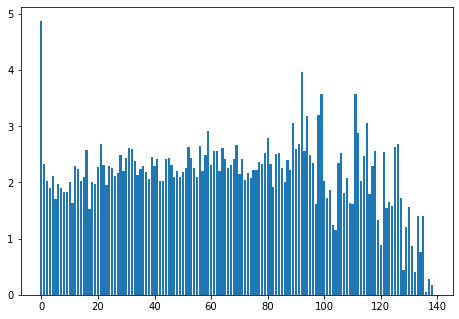

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

#plt.bar(count, height=10, width=0.8, bottom=None, align='center')

#ax.bar(range(0,len(count)),count)
#plt.show()

ax.bar(range(0,len(count)),mean_loss_per_token)
plt.show()